# Curriculum Learning in Crowd Counting


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, re, shutil, random
from pathlib import Path
from datetime import datetime
from glob import glob
import collections

from sklearn.model_selection import train_test_split
from PIL import Image
from scipy.ndimage import gaussian_filter
from skimage.io import imread_collection
from scipy.io import loadmat
from tqdm.notebook import tqdm
# from tqdm.auto import tqdm

import torch
from torchinfo import summary
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
import torchvision.transforms as T
# import albumentations as A
from torchvision.transforms import Lambda, Compose, PILToTensor, ToTensor
# !pip install visdom
# import visdom # creating, organizing, and sharing visualizations of live, rich data.

from IPython.display import clear_output

import cv2     # for capturing videos
import math    # for mathematical operations
# from skimage.transform import resize
# import natsort

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

sys.path.append('/home/muhammada/PDRA/works/cc_models/')
sys.path.append('/home/muhammada/PDRA/works/utils/')

''' SEED Everything '''
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True 
seed=42
seed_everything(seed=seed)

print("Using torch", torch.__version__) # colab= 1.10.0+cu111

Using torch 1.12.1+cu102


## 1. Load Data

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_load_data import load_data


i = 2
ds_names   = ['Mall', 'ShanghaiTechPartA', 'ShanghaiTechPartB', 'DroneRGBT', 'CARPK', 'UCSD', 'UCF_CC_50']
ds_name    = ds_names[i]
drive      = '/home/muhammada'         
root_dir   = drive + '/PDRA/works/cc_datasets/' + ds_names[i]
train_img_paths, train_gt_paths, val_img_paths, val_gt_paths, test_img_paths, test_gt_paths = load_data(root_dir=root_dir, ds_name=ds_name)

## Sort data by difficulty

In [ ]:
from sort_data import sort_data_bycount

### Method 1:  using actual count
### Arrange train paths and set "Shuffle=False" in train_daataloader.
count, train_img_paths, train_gt_paths = sort_data_bycount(train_img_paths, train_gt_paths, ds_name)
print(len(count))

### Method 2:  using counting errors (pretrained model: CSRNet).



## 2. Create Dataset

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# from dataset.DroneDataset import DroneDataset
from CrowdDataset import CrowdDataset # CrowdDataset2 uses image resizing
# from CrowdDatasetP import CrowdDatasetTrain, CrowdDatasetTest


## For dataset of same size
img_downsample = 1
gt_downsample  = 1 ## This is the model output size as compared to input
sigma     = 15
train_ds  =  CrowdDataset(train_img_paths, train_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes
val_ds    =  CrowdDataset(val_img_paths, val_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes
test_ds   =  CrowdDataset(test_img_paths, test_gt_paths, img_downsample, gt_downsample, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes

## For dataset of different size images
# img_size = (768, 1024, 3)
# ds       = 4 # CSRNet=8, CANNet=8, MCNN=4, LCDnet2=2, SANET=1
# gt_size  = (int(img_size[0]/ds), int(img_size[1]/ds))  # (3,192,256)
# sigma    = 10
# train_ds  =  CrowdDataset2(train_img_paths, train_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=True)  # img_size, gt_size = None for arbitrary shapes
# val_ds    =  CrowdDataset2(val_img_paths, val_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes
# test_ds   =  CrowdDataset2(test_img_paths, test_gt_paths, img_size, gt_size, ds_name, sigma=sigma, augmentation=False)  # img_size, gt_size = None for arbitrary shapes

#### Dataloaders
batch_size = 8
train_dl  = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=False) # pre_load=True
val_dl    = torch.utils.data.DataLoader(val_ds,   batch_size=1, num_workers=2, pin_memory=True, shuffle=False)
test_dl   = torch.utils.data.DataLoader(test_ds,  batch_size=1, num_workers=2, pin_memory=True, shuffle=False)


## Run
from cc_utils import display_sample
i = 10
img, gt, c = train_dl.dataset[i]
fig = display_sample(img, gt)
print(f'img => {img.shape} gt => {gt.shape}, count => {c}')





## Plot Pacing function

In [ ]:
# ###########  CL Set up
# from get_pacing_function import get_pacing_function
# batch_size = 2
# N               = len(train_ds)
# iter_per_epoch  = N//batch_size  
# M               = 32 # 32  # No. of samples to feed to the model in each iterations (256)
# n_iterations    = (N// batch_size+1)*n_epochs
# all_sum         = N/(n_iterations*(n_iterations+1)/2)
# pre_iterations  = 0
# startIter       = 0
# pacing_f        = 'linear'
# a               = 1
# b               = 1
# pacing_function = get_pacing_function(n_iterations, N, a, b, pacing_f)
# startIter_next  = pacing_function(2) # <=======================================


# order          = np.arange(0, len(train_ds))
# print(f' M {M}, startIter {startIter}, startIter_next {startIter_next}')

# train_dss      = Subset(train_ds, list(order[startIter:min(startIter_next, M)]))
# print(len(train_dss))
# train_dls      = torch.utils.data.DataLoader(train_dss, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True) 
# dataiter       = iter(train_dls)

# img, gt, c = train_dss[0]
# fig = display_sample(img, gt)
    

## Create Model

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_utils import save_checkpoint, load_checkpoint
from MCNN import MCNN
from CSRNet import CSRNet, CSRNet2
# from SANet import SANet
from TEDnet import TEDnet
from CANNet import CANNet
torch.backends.cudnn.enabled   = True
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
device   = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # torch.device("cuda")  ## 'cuda', 'cpu'

# Define Model
model_name = 'TEDnet'
models = {'MCNN':MCNN(), 'CSRNet':CSRNet(), 'CSRNet2':CSRNet2(), 'TEDnet':TEDnet()}
criterion    = nn.MSELoss(reduction='sum').to(device)  # MSELoss, L1Loss  ## reduction=sum, mean, none
model        = models[model_name].to(device)
# model        = nn.DataParallel(models[model_name]).to(device) # multiple GPU
optim        = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) # weight_decay=1e-3
lr_scheduler = None
n_epochs     = 10  
val_metric   = np.Inf
checkpoint   = f'{os.getcwd()}/checkpoints/{ds_name}_{model_name}_CL_linear.pt' 
params       = {'model': model, 'train_ds':train_ds, 'val_ds': val_ds,'n_epochs': n_epochs, 'batch_size':batch_size, 'device': device, 'optimizer': optim, 
                      'criterion':criterion,'lr_scheduler':lr_scheduler, 'val_metric': val_metric, 'checkpoint': checkpoint}
print(f'Model will be saved to >>>> {checkpoint}')

## Visualize the model
img, gt, count    =  train_ds[0] # (1,3,512,640)
input_size = img.unsqueeze(0).shape
print('Model Output', model(torch.rand(input_size).to(device)).shape)
# summary(model, input_size=input_size, col_width=20, col_names=["kernel_size", "output_size", "num_params", "mult_adds"]) # https://pypi.org/project/torchinfo/





## Training

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_cl_trainer import trainer
# params['val_metric'] = 0   #### For safety only (Comment when training new models)
history = trainer(params) ## 156R.xml

In [ ]:
## Predict
from cc_utils import display_prediction

i = 2 # Good: 6, 70  Bad:  3, 10, 17, 6, 134
img, gt, c = test_dl.dataset[i]
et         = model(img.unsqueeze(0).to(device))
fig        = display_prediction(img, gt, et) 

## Plot Learning Curve

In [ ]:
# plt.style.use('../torch_utils/scientific.mplstyle')
# df = pd.read_csv('./trained_models/history_MCNN.csv')
# history = df.to_dict("split")
# history = dict(zip(history["index"], history["data"]))

####  Plot Loss
from cc_utils import plot_loss
plot_loss(history)

## Load Best Model

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from cc_cl_trainer import trainer
from cc_utils import load_checkpoint

model_path    = f'{os.getcwd()}/checkpoints/{ds_name}_{model_name}_CL_linear.pt' 
optim         = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3, amsgrad=False) # 0.00001
# model         = nn.DataParallel(model)
model, optim, epoch, metric = load_checkpoint(model, optim, device, model_path)
# model.eval()  # For inference only
print(f'Model loaded: Last MAE {metric}')

## Load weights
# PATH     =  '/home/muhammada/PDRA/works/cc_all/weights/DroneRGBT_LCDnet.pth'  ##  backup
# model    = model().to(device)
# MCNN.load_state_dict(torch.load(PATH))
# MCNN.eval()  # For inference only
# print('\nMCNN loaded successfully.. \n')


### Further training
params['val_metric'] = metric
params['n_epochs']   = 200
history = trainer(params)

# writer.flush()
# writer.close()
#
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Save weights (state_dict)

In [ ]:
## Save weights only

# Save whole model
PATH = f'{os.getcwd()}/models/{ds_name}_{model_name}_CL_linear.pth'  ##  backup
torch.save(model, PATH)

# Save weights only
PATH = f'{os.getcwd()}/weights/{ds_name}_{model_name}_CL_linear.pth'  ##  backup
if isinstance(model, nn.DataParallel):
    print('Multi-GPU ==> Single-GPU before saving .. ')
    torch.save(model.module.state_dict(), PATH)
else:
    torch.save(model.state_dict(), PATH)


## 5. Predictions

### Predict a single image

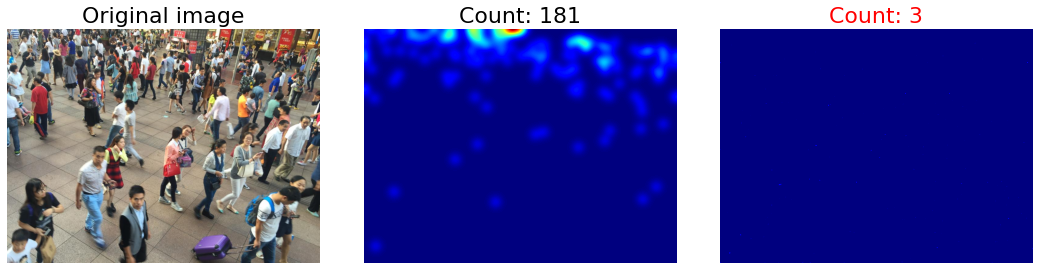

In [9]:
from cc_utils import display_prediction

i = 9 # Good: 3,   Bad:  3, 10, 17, 6, 134
img, gt, c = test_dl.dataset[i]
et      = model(img.unsqueeze(0).to(device))
fig     = display_prediction(img, gt, et)


In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from predict import predict


print('Predictions on test_data..')
test_images, test_gt, test_et, test_mae  = predict(model, test_dl, device=device)
# print('Test MAE', test_mae)

## 6. Plot counting errors

In [ ]:
## Test predictions
test_actual_count  = []
test_pred_count    = []
for i in range(0, len(test_gt)): # test_ds_unbatch.as_numpy_iterator():
    # print(f'Test:  Actual {test_dm[i,:].sum() :.0f} => Predicted {test_dm_h[i,:].sum() :.0f} ')
    test_actual_count.append(torch.sum(test_gt[i,:]))
    test_pred_count.append(torch.sum(test_et[i,:]))
test_actual_count  = torch.tensor(test_actual_count) #.detach().cpu()
test_pred_count    = torch.tensor(test_pred_count) #.detach().cpu()
test_mae2 = abs(test_actual_count - test_pred_count).sum()/len(test_dl.dataset)
print(f'Test MAE : {test_mae2}')

In [ ]:
### Test dataset
fig2, ax2 = plt.subplots(1, 1, figsize=(5,4))
p1 = max(max(test_actual_count), max(test_actual_count)).cpu()
p2 = min(min(test_pred_count), min(test_actual_count)).cpu()
ax2.plot([p1,p2], [p1,p2], 'r-')
ax2.plot(test_actual_count, test_pred_count, ls='', marker='o', markersize=5, markerfacecolor='w', markeredgecolor='blue', markeredgewidth=1, alpha=0.8)
plt.grid(alpha=0.3)
ax2.set_xlabel('Actual Count', fontsize=12, fontweight='medium')
ax2.set_ylabel('Predicted Count', fontsize=12, fontweight='medium')
# ax2.set_title(f'MAE (Test set) = {test_mae2 :.1f}', fontsize=12, fontweight='bold')
plt.savefig(f'SelfMCNN_errors.pdf', dpi=300, transparent=True)


## See some stats
threshold = 1
abs_error = abs(test_actual_count - test_pred_count)
count         = (abs_error<threshold).sum().numpy()
count_percent = (count/len(test_ds)) * 100
print(f'Images with (Counting Error < {threshold}) = , {count} which is {count_percent :.2f} %' )



## Density Classification

In [ ]:
# classes = [0,1,2,3,4] 
df_counts = pd.DataFrame(columns=['IMG', 'GT', 'ET'])
df_cls    = pd.DataFrame(columns=['IMG', 'GT', 'ET', 'Pred'])


df_counts['IMG']   = np.arange(0, len(test_actual_count))
df_counts['GT']    = test_actual_count.numpy()
df_counts['ET']    = test_pred_count.numpy()

df_cls = df_counts
df_cls.to_csv('df_cls.csv')

# df_cls['GT'].values[df_cls['GT'] < 21]  = 0   # 50
# df_cls['GT'].values[df_cls['GT'] > 150] = 4  # 29
# df_cls['GT'].values[df_cls['GT'] > 100] = 3  # 279
# df_cls['GT'].values[df_cls['GT'] > 50]  = 2   # 605
# df_cls['GT'].values[df_cls['GT'] > 20]  = 1   # 585

# df_cls['ET'].values[df_cls['ET'] < 21]  = 0   # 50
# df_cls['ET'].values[df_cls['ET'] > 150] = 4  # 29
# df_cls['ET'].values[df_cls['ET'] > 100] = 3  # 279
# df_cls['ET'].values[df_cls['ET'] > 50]  = 2   # 605
# df_cls['ET'].values[df_cls['ET'] > 20]  = 1   # 585

low  = 20
med   = 50
high   = 100

df_cls['GT'].values[df_cls['GT'] < low+1]  = 0   # 50
df_cls['GT'].values[df_cls['GT'] > high] = 3  # 279
df_cls['GT'].values[df_cls['GT'] > med]  = 2   # 605
df_cls['GT'].values[df_cls['GT'] > low]  = 1   # 585

df_cls['ET'].values[df_cls['ET'] < low+1]  = 0   # 50
df_cls['ET'].values[df_cls['ET'] > high] = 3  # 279
df_cls['ET'].values[df_cls['ET'] > med]  = 2   # 605
df_cls['ET'].values[df_cls['ET'] > low]  = 1   # 585

# Check stats
df_counts['Pred']    = np.arange(0, len(test_actual_count))
df_cls['Pred'] = np.where((df_cls['GT'] == df_cls['ET']) , 'Correct', 'Wrong')
df_final = pd.crosstab(df_cls.GT, df_cls.Pred)
df_final['Accuracy'] = (df_final['Correct']/ (df_final['Correct'] + df_final['Wrong'])) * 100

print(df_final)


##  Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_cls['GT'], df_cls['ET'])
print('Accuracy', accuracy)

## Feature maps

In [ ]:
## Visualize output feature map of single column

model_weights  = [] 
conv_layers    = [] 
model_children = list(model.children())  # get all the model children as list
# print(model_children) # Run to make sure the list contains all layers of the model

layer_no = 0 
for child in model_children:
    if type(child) == nn.Conv2d:
        layer_no += 1
        model_weights.append(child.weight)
        conv_layers.append(child)
        
    elif type(child) == nn.Sequential:
            for layer in child.children():
                if type(layer) == nn.Conv2d:
                    layer_no += 1
                    model_weights.append(layer.weight)
                    conv_layers.append(layer)
print(f"Total convolutional layers: {len(conv_layers)}")

outputs, names = [],[]
# image = img.permute(2,0,1).unsqueeze(0)
img, gt = train_dl.dataset[100]
img = img.to(device)

conv1_out = conv_layers[0](img)
# print(img.shape)
outputs.append(img)
names.append(str(layer))

for layer in conv_layers[1:4]:  ## 0:4 (first column), 4:8 (2nd column), 8:11 (3rd column), 11 (fuse Conv layer)
    # img = layer(img.to(device))
    # print(img.shape)
    outputs.append(conv1_out)
    names.append(str(layer))

## Convert 3D tensors to 2D tensors
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)    
    gray_scale = torch.sum(feature_map,0)  # Sum the same elements of every channels
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

## Plot feature maps    
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
# plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')